In [1]:
#import  tushare as ts
import  torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
import numpy as np
#import pandas_datareader as web
#from pandas_datareader import data as web
from torch.autograd import Variable
import os
import math
import scipy.optimize
import pandas as pd
#import yfinance as yf
from torchvision import transforms
import numpy as np
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
#from torchsummary import summary
import matplotlib.pyplot as plt

In [ ]:
import tushare as ts
pro= ts.pro_api('95070031083efcfa3b3b61dc543db8e9c8749a638939ed2fea293e64')
pa=pro.daily(ts_code='600519.SH', start_date='20120103',end_date='20200229')
print(pa)
pa.index = pd.to_datetime(pa.trade_date)
pa.sort_index(inplace=True)
pa.drop(axis=1, columns='trade_date', inplace=True)
print(pa.head())
pa.to_csv('MT.csv')
df = pa
#df=pro.get_k_data('600519',start='2018-06-17', end='2021-12-13',autype='qfq')
#df = pro.get_h_data('600519',start='2011-01-01', end='2020-05-29')
#print(df)
#print(df)

In [2]:
df=pd.read_csv("AAPL.csv")
df_A=pd.read_csv("AAPL.csv")
print(df_A)
df_A.index = pd.to_datetime(df_A.Date)
df_A.sort_index(inplace=True)
df_A.drop(axis=0, columns='Date', inplace=True)
print(df_A.head())
#df = df_A
#print(df.astype)
#df=df.sort_index(ascending=True)
#print(df.astype)

            Date       Open       High        Low      Close  Adj Close  \
0     2012-01-03  14.621429  14.732143  14.607143  14.686786  12.610315   
1     2012-01-04  14.642857  14.810000  14.617143  14.765714  12.678082   
2     2012-01-05  14.819643  14.948214  14.738214  14.929643  12.818839   
3     2012-01-06  14.991786  15.098214  14.972143  15.085714  12.952842   
4     2012-01-09  15.196429  15.276786  15.048214  15.061786  12.932295   
...          ...        ...        ...        ...        ...        ...   
2109  2020-05-21  79.665001  80.222504  78.967499  79.212502  78.564629   
2110  2020-05-22  78.942497  79.807503  78.837502  79.722504  79.070457   
2111  2020-05-26  80.875000  81.059998  79.125000  79.182503  78.534874   
2112  2020-05-27  79.035004  79.677498  78.272499  79.527496  78.877045   
2113  2020-05-28  79.192497  80.860001  78.907501  79.562500  78.911751   

         Volume  
0     302220800  
1     260022000  
2     271269600  
3     318292800  
4     394

In [3]:
train_start = '2012-01-03'
train_end = '2019-02-27'
test_start = '2019-03-03' #need additional 7 days as given info
test_end = '2020-02-29'
data_frame = df_A.resample('1D',label = 'left',closed = 'right').sum()[train_start:test_end]
data_frame.fillna(0, inplace=True)


In [4]:
torch.cuda.is_available()

True

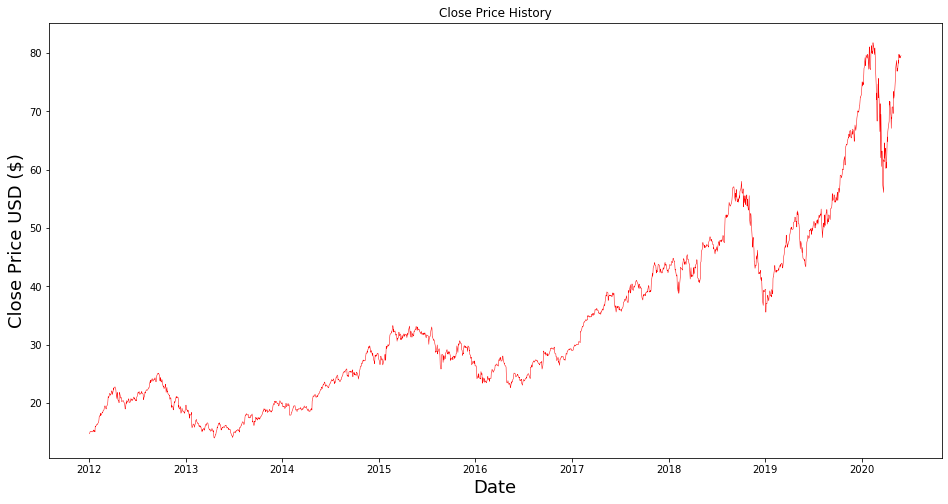

In [5]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df_A['Close'], 'r',linewidth=0.5)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.savefig('tt.png')
plt.show()

In [6]:
#dataset = web.DataReader('AAPL',data_source='yahoo', start='2012-01-01',end='2020-05-29')
dataset = df_A
df_close = dataset.filter(['Close'])

In [7]:
print(df_close.shape)

(2114, 1)


In [8]:
# 提取open,close,high,low,vol 作为feature,并做标准化
df=df[["Close"]]
close_min=df['Close'].min()
close_max=df["Close"].max()
df=df.apply(lambda x:(x-min(x))/(max(x)-min(x)))

In [9]:
print(np.array(df.iloc[0:1,].values))

[[0.01089548]]


In [10]:
# 定义X和Y: 根据前n天的数据，预测当天的收盘价
# 例如根据 1月1日，1月2日，1月3日 的价格预测 1月4日的收盘价
# X=[ ["open1","close1","high1","low1","vol1"] ,["open2","close2","high2","low2","vol2"] ,["open3","close3","high3","low3","vol3"] ]
# Y=[ close4 ]
# 那么X对应的sequence=3 ， [ input_size=5(5维度) ，这tm就是nlp中每个词的embedding ]

total_len=df.shape[0]
sequence=60
day = 5
X=[]
Y=[]
for i in range(df.shape[0]-sequence-day):
    X.append(np.array(df.iloc[i:(i+sequence),].values,dtype=np.float32))
    Y.append(np.array(df.iloc[(i+sequence):(i+sequence+day),0],dtype=np.float32))

print(X[0])
print(Y[0])


[[0.01089548]
 [0.01205871]
 [0.01447467]
 [0.01677483]
 [0.01642217]
 [0.01721696]
 [0.01685378]
 [0.01624321]
 [0.01541157]
 [0.01798544]
 [0.02030665]
 [0.01959081]
 [0.01566948]
 [0.01941185]
 [0.01572739]
 [0.02954412]
 [0.02847564]
 [0.02987047]
 [0.03288645]
 [0.03471288]
 [0.03456025]
 [0.03399706]
 [0.03639722]
 [0.03865526]
 [0.04121334]
 [0.04534521]
 [0.05402474]
 [0.05415633]
 [0.05898825]
 [0.06259901]
 [0.05639334]
 [0.05878296]
 [0.0587356 ]
 [0.06543606]
 [0.06448335]
 [0.06624662]
 [0.06941526]
 [0.07117856]
 [0.07625785]
 [0.07995808]
 [0.08102658]
 [0.08140031]
 [0.07507356]
 [0.07354712]
 [0.07377347]
 [0.07972125]
 [0.08139504]
 [0.08499003]
 [0.09346429]
 [0.10477033]
 [0.10265438]
 [0.10265964]
 [0.11083389]
 [0.11339198]
 [0.11157078]
 [0.10990752]
 [0.10817582]
 [0.11392883]
 [0.11787648]
 [0.11952922]]
[0.11544473 0.11001805 0.12006085 0.12568752 0.12305051]


In [11]:
#重写Dataset
class Mydataset(Dataset):
    def __init__(self,xx,yy,transform=None):
        self.x=xx
        self.y=yy
        self.tranform = transform

    def __getitem__(self,index):
        x1=self.x[index]
        y1=self.y[index]
        if self.tranform !=None:
            return self.tranform(x1),y1
        return x1,y1

    def __len__(self):
        return len(self.x)

In [12]:
# # 构建batch
train_num = 0.8
trainx,trainy=X[:int(train_num*total_len)],Y[:int(train_num*total_len)]
testx,testy=X[int(train_num*total_len):],Y[int(train_num*total_len):]
train_loader=DataLoader(dataset=Mydataset(trainx,trainy,transform=transforms.ToTensor()), batch_size=16, shuffle=False)
test_loader=DataLoader(dataset=Mydataset(testx,testy), batch_size=16, shuffle=False)

In [13]:
print(Y[0].shape)
print(X[1].shape)
print(len(Y))
print(Y[6])

(5,)
(60, 1)
2049
[0.12932463 0.12522435 0.12404533 0.12223992 0.11300772]


In [14]:
class lstm(nn.Module):

    def __init__(self,input_size=1,hidden_size=64,output_size=5):
        super(lstm, self).__init__()
        # lstm的输入 #batch,seq_len, input_size
        self.hidden_size=hidden_size
        self.input_size=input_size
        self.output_size=output_size
        self.rnn=nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size,batch_first=True)
        self.linear=nn.Linear(self.hidden_size,self.output_size)
    def forward(self,x):
        out,(hidden,cell)=self.rnn(x)  # x.shape : batch,seq_len,hidden_size , hn.shape and cn.shape : num_layes * direction_numbers,batch,hidden_size
        a,b,c=hidden.shape
        out=self.linear(hidden.reshape(a*b,c))
        
        return out

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model=lstm().to(device)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

epoch1: loss:0.036040
epoch2: loss:0.035964
epoch3: loss:0.036001
epoch4: loss:0.035792
epoch5: loss:0.035569
epoch6: loss:0.035539
epoch7: loss:0.035514
epoch8: loss:0.035316
epoch9: loss:0.035368
epoch10: loss:0.035149
epoch11: loss:0.035213
epoch12: loss:0.035076
epoch13: loss:0.034904
epoch14: loss:0.035002
epoch15: loss:0.035063
epoch16: loss:0.035400
epoch17: loss:0.035372
epoch18: loss:0.036086
epoch19: loss:0.036653
epoch20: loss:0.036660
epoch21: loss:0.035957
epoch22: loss:0.035897
epoch23: loss:0.035973
epoch24: loss:0.035834
epoch25: loss:0.035305
epoch26: loss:0.035096
epoch27: loss:0.034932
epoch28: loss:0.034843
epoch29: loss:0.034888
epoch30: loss:0.034506
epoch31: loss:0.034505
epoch32: loss:0.034294
epoch33: loss:0.034145
epoch34: loss:0.034468
epoch35: loss:0.033065
epoch36: loss:0.033922
epoch37: loss:0.033960
epoch38: loss:0.033736
epoch39: loss:0.033736
epoch40: loss:0.033737
epoch41: loss:0.033296
epoch42: loss:0.033478
epoch43: loss:0.033922
epoch44: loss:0.0339

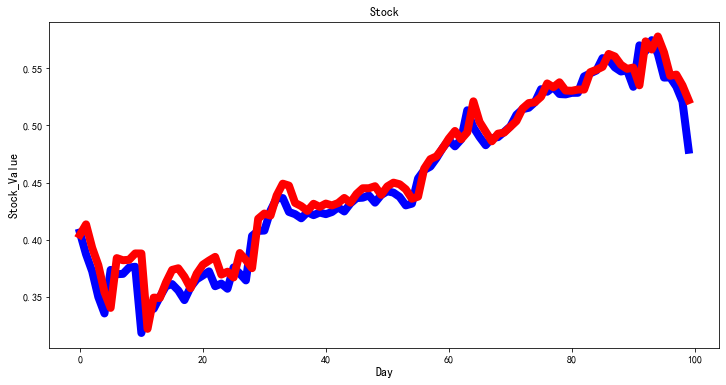

In [41]:
preds=[]
labels=[]
kk=1
for i in range(120):
    total_loss=0
    for idx,(data,label) in enumerate(train_loader):

        data1=data.to(device).squeeze(1)
        pred=model(Variable(data1))
        label=label.to(device)
        #label=label.unsqueeze(1)

        loss=criterion(pred,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
    if (i+1)%1 == 0:
        print("epoch%d: loss:%f"%(i+1,total_loss))
# 开始测试
preds=[]
labels=[]
total_loss = 0
for idx, (x, label) in enumerate(test_loader):
    x = x.to(device).squeeze(1)  # batch_size,seq_len,input_size
    pred=model(x)
    label=label.to(device)
    loss=criterion(pred,label)
    total_loss+=loss.item()
    preds.extend(pred.data.squeeze(1).tolist())
    labels.extend(label.tolist())
true_stock = []
pred_stock = []
for i in range(len(labels)):
    true_stock.append(labels[i][0])
    pred_stock.append(preds[i][0])
print("test loss: ",total_loss)

#display
start_day = 0
dis_day = 100
plt.figure(figsize=(12,6))
plt.title('Stock')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Stock_Value', fontsize = 12)
plt.plot(true_stock[start_day:dis_day],"b",label="True",linewidth=8)
plt.plot(pred_stock[start_day:dis_day],"r",label="Pred",linewidth=8)

plt.show()

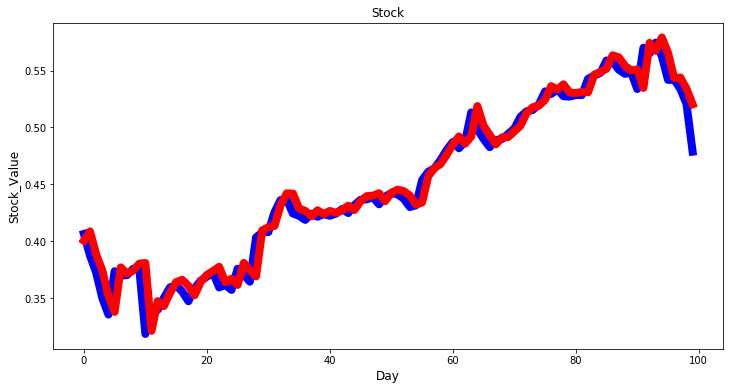

In [17]:
start_day = 0
dis_day = 100
plt.figure(figsize=(12,6))
plt.title('Stock')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Stock_Value', fontsize = 12)
plt.plot(true_stock[start_day:dis_day],"b",label="True",linewidth=8)
plt.plot(pred_stock[start_day:dis_day],"r",label="Pred",linewidth=8)
plt.show()

In [18]:
def fgsm_attack(data, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    adv_data = data + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    #adv_data = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    
    return adv_data

In [19]:
def pgd_attack(data,epsilon, pertubation,iter_eps, label, criterion, model):
    adv_x = data + pertubation
    adv_x.requires_grad = True
    pred = model(adv_x)
    loss = criterion(pred,label)
    model.zero_grad()
    loss.backward()
    data_grad = adv_x.grad.data
    sign_data_grad = data_grad.sign()
    pertubation = iter_eps * sign_data_grad
    # Collect the element-wise sign of the data gradient
    adv_x=adv_x.detach()+ pertubation
    data=data.detach()
    
    pertubation=torch.clamp(adv_x-data,-epsilon,epsilon)
    #print(pertubation.type())
    # Create the perturbed image by adjusting each pixel of the input image
    return pertubation

In [20]:
def predict_classes(x, data,label, model, pertubation):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    seq_perturbed = []
    #print(pertubation)
    for i in range(len(x)):
        if x[i] >= 0.5:
            seq_perturbed.append(pertubation[0][i][0])
        else:
            seq_perturbed.append(data[0][i][0])
    
    seq_perturbed = torch.tensor(seq_perturbed)
    seq_perturbed = seq_perturbed.view([1,len(x),1])
    seq_perturbed = seq_perturbed.to(device).float()
    predictions = model(seq_perturbed)
    label = label.to(device)
    loss=criterion(predictions,label)
    # This function should always be minimized, so return its complement if needed
    return 100 - loss
def attack_success(x, data, label, target_loss_data, model, pertubation):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_seq = []
    for i in range(len(x)):
        if x[i] >= 0.5:
            attack_seq.append(pertubation[0][i][0])
        else:
            attack_seq.append(data[0][i][0])
    attack_seq = torch.tensor(attack_seq)
    attack_seq = attack_seq.view([1,len(x),1])
    target_loss_data = target_loss_data.to(device)
    attack_seq = attack_seq.to(device).float()
    label = label.to(device)
    pre_loss = model(target_loss_data)
    predictions = model(attack_seq)
    loss = criterion(predictions,label)
    loss_standard = criterion(pre_loss,label)
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True

    if loss >= (loss_standard*100):
        print("success attack!")
        return True
    # NOTE: return None otherwise (not False), due to how Scipy handles its callback function

In [34]:
def all_attack(model, criterion, test_loader, device,epsilon):
    preds=[]
    adv_preds=[]
    adv_preds_list=[]
    test_x=[]
    test_adv=[]
    num_iter = 50
    iter_eps = 0.02
    #epsilon = 0.08
    total_loss = 0
    adv_total_loss = 0
    for idx, (x, label) in enumerate(test_loader):
        x = x.to(device).squeeze(1)  # batch_size,seq_len,input_size
        pred=model(x)
        label = label.to(device)
        loss=criterion(pred,label)
        pertubation = torch.zeros(x.shape)
        pertubation = pertubation.to(device)
        for i in range(num_iter):
            pertubation = pgd_attack(x,epsilon, pertubation,iter_eps, label, criterion, model) # PGD
        perturbed_data = x + pertubation
        adv_pred=model(perturbed_data)
        adv_loss=criterion(adv_pred,label)
        for i in range(len(x)):
            test_x.append(x[i][0][0])
            test_adv.append(perturbed_data[i][0][0])  
        total_loss+=loss.item()
        adv_total_loss+=adv_loss.item()
        preds.extend(pred.data.squeeze(1).tolist())
        adv_pred = adv_pred.detach().cpu()
        adv_preds.extend(adv_pred.data.squeeze(1).tolist())
        
    for i in range(len(adv_preds)):
        adv_preds_list.append(adv_preds[i][0])
    print("all_attack_RMSE: ")
    print("loss: ",total_loss)
    print("adv_loss: ",adv_total_loss)
    return adv_preds_list, adv_total_loss, test_adv

def part_attack(model, criterion, test_loader, device, epsilon):
    preds=[]
    adv_part_preds=[]
    adv_part_preds_list= []
    labels=[]
    test_part_adv=[]
    test_ori_adv = []
    num_iter = 50
    iter_eps = 0.02
    #epsilon = 0.06
    total_loss = 0
    adv_part_total_loss = 0
    #part jiange
    gap = 8
    #raodong qujian
    adv_len = 8
    for idx, (x, label) in enumerate(test_loader):
        x = x.to(device).squeeze(1)  # batch_size,seq_len,input_size
        pred=model(x)
        label = label.to(device)
        loss=criterion(pred,label)
        pertubation=torch.zeros(x.shape)
        pertubation = pertubation.to(device)
        for i in range(num_iter):
            pertubation = pgd_attack(x,epsilon, pertubation,iter_eps, label, criterion, model) # PGD
        for i in range(len(x)):
            # sequence=60
            for j in range(0,len(pertubation[i])):
                if i%(adv_len+gap)<gap and j == 0:
                    pertubation[i][j:j+gap-i%(adv_len+gap)] = 0
                if (j+i) % (adv_len+gap) == 0 and j != 0:
                    pertubation[i][j:j+gap] = 0
        perturbed_data = x + pertubation
        adv_part_pred=model(perturbed_data)
        adv_loss=criterion(adv_part_pred,label)
        for i in range(len(x)):
            test_part_adv.append(perturbed_data[i][0][0])  
            test_ori_adv.append(x[i][0][0])
        total_loss+=loss.item()
        adv_part_total_loss+=adv_loss.item()
        preds.extend(pred.data.squeeze(1).tolist())
        adv_part_preds.extend(adv_part_pred.data.squeeze(1).tolist())
        
        labels.extend(label.tolist())
    for i in range(len(adv_part_preds)):
        adv_part_preds_list.append(adv_part_preds[i][0])
    print("part_attack_RMSE:")
    print("loss: ",total_loss)
    print("adv_part_loss: ",adv_part_total_loss)
    
    return adv_part_preds_list, adv_part_total_loss, test_part_adv, test_ori_adv
def get_DE_data(data_loader, dis_day, test_part_adv, epsilon, sequence, day):
    num_iter = 50
    iter_eps = 0.02
    #epsilon = 0.06
    data_x=[]
    data_adv=[]
    test_all_adv = []
    for idx, (x, label) in enumerate(data_loader):
        x = x.to(device).squeeze(1)  # batch_size,seq_len,input_size
        pred=model(x)
        label = label.to(device)
        loss=criterion(pred,label)
        
        pertubation=torch.zeros(x.shape)
        pertubation = pertubation.to(device)
        for i in range(num_iter):
            pertubation = pgd_attack(x,epsilon, pertubation,iter_eps, label, criterion, model) # PGD
        perturbed_data = x + pertubation
        for i in range(len(x)):
            data_x.append(x[i][0][0])
            test_all_adv.append(perturbed_data[i][0][0])
    seq_b = dis_day
    seq_o = dis_day + sequence
    seq_loss_data = test_part_adv[seq_b:seq_o]
    seq_data = data_x[seq_b:seq_o]
    seq_adv_data = test_part_adv[seq_b:seq_o]
    all_adv_data = test_all_adv[seq_b:seq_o]
    seq_label = data_x[seq_o + 1:seq_o + day+1]
    seq_data = torch.tensor(seq_data)
    seq_adv_data = torch.tensor(seq_adv_data)
    seq_loss_data = torch.tensor(seq_loss_data)
    all_adv_data = torch.tensor(all_adv_data)
    seq_label = torch.tensor(seq_label)
    seq_label = seq_label.view([1,day])
    seq_data = seq_data.view([1,sequence,1])
    seq_adv_data = seq_adv_data.view([1,sequence,1])
    seq_loss_data = seq_loss_data.view([1,sequence,1])
    all_adv_data = all_adv_data.view([1,sequence,1])
    
    #to device
    all_adv_data = all_adv_data.to(device).float()
    seq_data = seq_data.to(device).float()
    seq_adv_data = seq_adv_data.to(device).float()
    #predict
    ori_predictions = model(seq_data)
    #print(seq_data)
    all_attack_predictions = model(all_adv_data)
    #print(all_adv_data)
    part_attack_predictions = model(seq_adv_data)
    #print(seq_adv_data)
    seq_label = seq_label.to(device)
    part_attack_loss = criterion(part_attack_predictions, seq_label)
    all_attack_loss = criterion(all_attack_predictions, seq_label)
    ori_loss=criterion(ori_predictions,seq_label)
    print("Original_loss:",ori_loss)
    print("All_attack_loss:", all_attack_loss)
    print("Part_attack_loss:", part_attack_loss)
    seq_adv_data = seq_adv_data.detach().cpu()
    seq_data = seq_data.detach().cpu()

    return seq_data, seq_adv_data, seq_label, seq_loss_data
def attack(x_test,pertubation, seq_loss_data, model,label, maxiter=60, popsize=600):
    # Define bounds for a flat vector of x values
    # For more pixels, repeat this layout
    bounds = []
    for i in range(0,sequence):
        bounds.append((0,1))
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    # Zero all existing gradients
    # Calculate gradients of model in backward pass
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, seq_data, seq_label, model, pertubation)
    def callback_fn(x, convergence):
        return attack_success(x, x_test, label, seq_loss_data, model, pertubation)
    #print("dwdw")
    # Call Scipy's Implementation of Differential Evolution
    attack_result = scipy.optimize.differential_evolution(predict_fn, bounds, strategy = 'best2bin', maxiter=maxiter, popsize=popmul, mutation=0.5,
        recombination=0.1, atol=-1, callback=callback_fn, polish=False)
    # Calculate some useful statistics to return from this function
    res_attack_seq = []
    DE_sample = []
    res = attack_result.x
    for i in range(len(res)):
        if res[i] >= 0.5:
            res_attack_seq.append(pertubation[0][i][0])
            DE_sample.append(pertubation[0][i][0])
        else:
            res_attack_seq.append(x_test[0][i][0])
            DE_sample.append(x_test[0][i][0])
    res_attack_seq = torch.tensor(res_attack_seq)
    res_attack_seq = res_attack_seq.view([1,len(res),1])
    res_attack_seq = res_attack_seq.to(device).float()
    predictions = model(res_attack_seq)
    label = label.to(device)
    DE_loss=criterion(predictions,label)
    
    print("adv_part_DE_loss: ", DE_loss)
    print(predictions)
    return predictions, DE_sample

In [45]:
dis_day = 3
epsilon = 0.1
adv_preds = []
adv_part_preds = []
part_DE_sample = []
adv_preds, all_attack_loss, test_all_adv = all_attack(model, criterion, test_loader,device, epsilon)
adv_part_preds, part_attack_loss,test_part_adv,test_ori_adv = part_attack(model, criterion, test_loader,device,epsilon)
seq_data, seq_adv_data, seq_label, seq_loss_data = get_DE_data(test_loader, dis_day, test_part_adv,epsilon,sequence,day)
# DE+part
adv_part_DE_preds, part_DE_sample = attack(seq_data,seq_adv_data,seq_loss_data, model,seq_label)
adv_part_DE_preds = adv_part_DE_preds.detach().cpu().numpy()


all_attack_RMSE: 
loss:  0.025015565843204968
adv_loss:  0.5147961396723986
part_attack_RMSE:
loss:  0.025015565843204968
adv_part_loss:  0.2519108750857413
Original_loss: tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
All_attack_loss: tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)
Part_attack_loss: tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)
adv_part_DE_loss:  tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([[0.4872, 0.4851, 0.4836, 0.4874, 0.4874]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


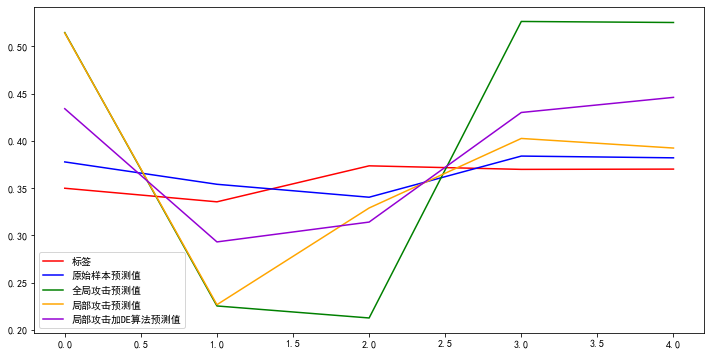

<Figure size 432x288 with 0 Axes>

In [52]:
plt.rcParams['font.sans-serif']='SimHei' #设置中文显示
plt.figure(figsize=(12,6))
#plt.title('预测结果')
plt.plot(labels[dis_day],"r",label="标签")
plt.plot(pred_stock[dis_day:dis_day+day],"b",label="原始样本预测值")
plt.plot(adv_preds[dis_day:dis_day+day],"green",label="全局攻击预测值")
plt.plot(adv_part_preds[dis_day:dis_day+day],"orange",label="局部攻击预测值")
plt.plot(adv_part_DE_preds,"darkviolet",label="局部攻击加DE算法预测值")
plt.legend(loc='best')
plt.show()
plt.savefig('stock_0.06_6.png',dpi=600)


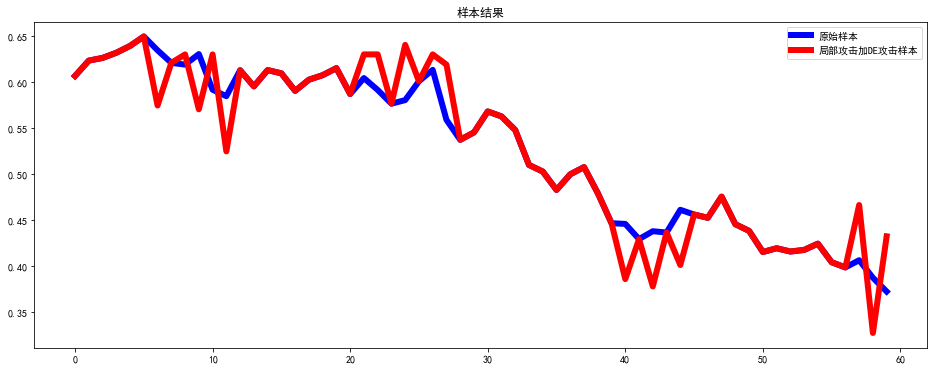

全局攻击后样本与原始样本数据的相关系数： 0.8113402780714014
局部攻击后样本与原始样本数据的相关系数： 0.8850356259707959
局部和DE攻击后样本与原始样本数据的相关系数： 0.9531837612120007
All_Sample RMSE: tensor(0.0036)
Part_Sample RMSE: tensor(0.0019)
Part_DE_Sample RMSE: tensor(0.0007)


D:\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

In [39]:
part_sample = []
all_sample = []
ori_sample = []


part_sample = test_part_adv[dis_day:dis_day+sequence]
all_sample = test_all_adv[dis_day:dis_day+sequence]
ori_sample = test_ori_adv[dis_day:dis_day+sequence]

plt.rcParams['font.sans-serif']='SimHei' #设置中文显示
plt.figure(figsize=(16,6))

plt.title('样本结果')

#plt.plot(all_sample,"r",label="全局攻击样本",linewidth=6)
#plt.plot(part_sample,"r",label="局部攻击样本",linewidth=6)
plt.plot(part_DE_sample,"r",label="局部攻击加DE攻击样本",linewidth=6)
plt.legend(loc='best')
plt.show()

#plt.subplot(212)
#plt.figure(figsize=(16,6))
#plt.title('Sample result')
# for i in range(len(part_DE_sample[bi:ov])):
#     dis_ALL.append(all_sample[bi+i])
# plt.plot(ori_sample[bi:ov],"b",label="原始样本",linewidth=3)
# plt.plot(dis_ALL,"r",label="对抗样本",linewidth=3)
# #plt.plot(part_sample,"orange",label="Part_attack Sample",linewidth=3)
# #plt.plot(part_DE_sample[bi:ov],"darkviolet",label="Part_DE_attack Sample",linewidth=3)
# plt.legend(loc='best')
# plt.savefig('./Result_example.jpg')
# plt.show()

ori_sample = torch.tensor(ori_sample, device='cpu')
all_sample = torch.tensor(all_sample, device='cpu')
part_sample = torch.tensor(part_sample, device='cpu')

label_corr = pd.Series(np.array(ori_sample))
all_corr = pd.Series(np.array(all_sample))
part_corr = pd.Series(np.array(part_sample))
DE_corr = pd.Series(np.array(part_DE_sample))



all_corr_r=label_corr.corr(all_corr,method = 'pearson')
part_corr_r=label_corr.corr(part_corr,method = 'pearson')
DE_corr_r=label_corr.corr(DE_corr,method = 'pearson')

print('全局攻击后样本与原始样本数据的相关系数：', all_corr_r)
print('局部攻击后样本与原始样本数据的相关系数：', part_corr_r)
print('局部和DE攻击后样本与原始样本数据的相关系数：', DE_corr_r)



all_sample = torch.tensor(all_sample)
ori_sample = torch.tensor(ori_sample)
part_sample = torch.tensor(part_sample)
part_DE_sample = torch.tensor(part_DE_sample)
print("All_Sample RMSE:", criterion(all_sample, ori_sample))
print("Part_Sample RMSE:", criterion(part_sample, ori_sample))
print("Part_DE_Sample RMSE:", criterion(part_DE_sample, ori_sample))